# Cross-Attention Heatmap Visualization (Full Matrix)

Visualize raw 2D attention maps (Query Frame × Key Frame) for all heads in a specified layer.

- **X-axis**: Key Frame Index (0-20)
- **Y-axis**: Query Frame Index (0-20)
- **Layout**: 3×4 grid for 12 heads

**Note**: Due to causal attention, the matrix is lower-triangular (frames can only attend to previous or current frames).

In [1]:
import math
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch

# Plot style settings
plt.style.use("seaborn-v0_8-whitegrid")
sns.set_palette("husl")

plt.rcParams.update(
    {
        "svg.fonttype": "none",
        "font.family": "sans-serif",
        "font.sans-serif": ["Arial", "DejaVu Sans", "Helvetica"],
        "font.size": 11,
        "axes.labelsize": 12,
        "axes.titlesize": 13,
        "xtick.labelsize": 10,
        "ytick.labelsize": 10,
        "legend.fontsize": 10,
        "figure.dpi": 150,
        "savefig.dpi": 300,
        "savefig.bbox": "tight",
        "savefig.pad_inches": 0.1,
    }
)

In [2]:
# ========== Data Loading ==========
# Option 1: Load full attention matrix (from run_extraction_full_attention.py)
# Option 2: Fall back to last-block-only data (from run_extraction_figure4.py)

FULL_MATRIX_PATH = "../cache/attention_full_matrix.pt"
LAST_BLOCK_PATH = "../cache/attention_cache_wan_base.pt"

# Try to load full matrix first
if Path(FULL_MATRIX_PATH).exists():
    data = torch.load(FULL_MATRIX_PATH, map_location="cpu", weights_only=False)
    DATA_TYPE = "full_matrix"
    print(f"Loaded FULL MATRIX data from: {FULL_MATRIX_PATH}")
elif Path(LAST_BLOCK_PATH).exists():
    data = torch.load(LAST_BLOCK_PATH, map_location="cpu", weights_only=False)
    DATA_TYPE = "last_block"
    print(f"Loaded LAST BLOCK data from: {LAST_BLOCK_PATH}")
    print("WARNING: Only the last block's attention is available (query frames 18-20).")
    print("Run run_extraction_full_attention.py to get full 21x21 matrix.")
else:
    raise FileNotFoundError(
        f"No attention data found!\n"
        f"Please run one of:\n"
        f"  PYTHONPATH=. python experiments/run_extraction_full_attention.py --no_checkpoint\n"
        f"  PYTHONPATH=. python experiments/run_extraction_figure4.py --no_checkpoint"
    )

print("=" * 70)
print("Attention Data Summary")
print("=" * 70)
print(f'Prompt: {data.get("prompt", "N/A")}')
print(f'Total frames: {data.get("num_frames", "N/A")}')
print(f'Capture method: {data.get("capture_method", "N/A")}')
print(f'Data type: {DATA_TYPE}')

Loaded FULL MATRIX data from: ../cache/attention_full_matrix.pt
Attention Data Summary
Prompt: A majestic eagle soaring through a cloudy sky, cinematic lighting
Total frames: 21
Capture method: full_matrix_all_blocks
Data type: full_matrix


In [3]:
# ========== Process Data Based on Type ==========

attention_weights = data["attention_weights"]
num_frames = data.get("num_frames", 21)
frame_seq_length = data.get("frame_seq_length", 1560)

# Build attention data dict
layer_attention_data = {}

for w in attention_weights:
    layer_idx = w["layer_idx"]

    if DATA_TYPE == "full_matrix":
        # Full matrix format: [num_heads, num_frames, num_frames]
        frame_attn = w["full_frame_attention"].float().numpy()
        num_q_frames = frame_attn.shape[1]
        num_k_frames = frame_attn.shape[2]
        query_frame_indices = list(range(num_q_frames))
        key_frame_indices = list(range(num_k_frames))
    else:
        # Last block format: [batch, num_heads, Lq, Lk] - need to aggregate
        attn = w["attn_logits"][0].float().numpy()  # [num_heads, Lq, Lk]
        num_heads, lq, lk = attn.shape
        fsl = w.get("frame_seq_length", frame_seq_length)
        num_q_frames = lq // fsl
        num_k_frames = lk // fsl

        # Compute frame-level attention
        frame_attn = np.zeros((num_heads, num_q_frames, num_k_frames))
        for h in range(num_heads):
            head_attn = attn[h]
            for qf in range(num_q_frames):
                for kf in range(num_k_frames):
                    q_start = qf * fsl
                    q_end = (qf + 1) * fsl
                    k_start = kf * fsl
                    k_end = (kf + 1) * fsl
                    frame_attn[h, qf, kf] = head_attn[q_start:q_end, k_start:k_end].mean()

        query_frame_indices = data.get("query_frames", [18, 19, 20])
        key_frame_indices = list(range(num_k_frames))

    layer_attention_data[layer_idx] = {
        "frame_attention": frame_attn,  # [num_heads, num_q_frames, num_k_frames]
        "query_frame_indices": query_frame_indices,
        "key_frame_indices": key_frame_indices,
        "num_heads": frame_attn.shape[0],
        "num_q_frames": num_q_frames,
        "num_k_frames": num_k_frames,
    }

    # print(f"Layer {layer_idx}: {num_heads} heads, Q={num_q_frames} frames, K={num_k_frames} frames")
    # print(f"  Range: [{frame_attn.min():.4f}, {frame_attn.max():.4f}]")

In [4]:
# ========== Select Layer to Visualize ==========
LAYER_TO_VISUALIZE = 0  # Change to 4 or other available layers

if LAYER_TO_VISUALIZE not in layer_attention_data:
    available = list(layer_attention_data.keys())
    raise ValueError(f"Layer {LAYER_TO_VISUALIZE} not found. Available: {available}")

layer_data = layer_attention_data[LAYER_TO_VISUALIZE]
frame_attn_2d = layer_data["frame_attention"]  # [num_heads, Q, K]
query_frames = layer_data["query_frame_indices"]
key_frames = layer_data["key_frame_indices"]
num_heads = layer_data["num_heads"]
num_q_frames = layer_data["num_q_frames"]
num_k_frames = layer_data["num_k_frames"]

print(f"Selected Layer: {LAYER_TO_VISUALIZE}")
print(f"Attention shape: {frame_attn_2d.shape}")
print(f"Query frames: {query_frames[:5]}... ({num_q_frames} total)")
print(f"Key frames: {key_frames[:5]}... ({num_k_frames} total)")

Selected Layer: 0
Attention shape: (12, 21, 21)
Query frames: [0, 1, 2, 3, 4]... (21 total)
Key frames: [0, 1, 2, 3, 4]... (21 total)


Plotting 2D Attention Maps for Layer 0


/tmp/ipykernel_4383/361087167.py:83: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.92, 0.98])


Saved: cross_attention_layer0_all_heads.svg


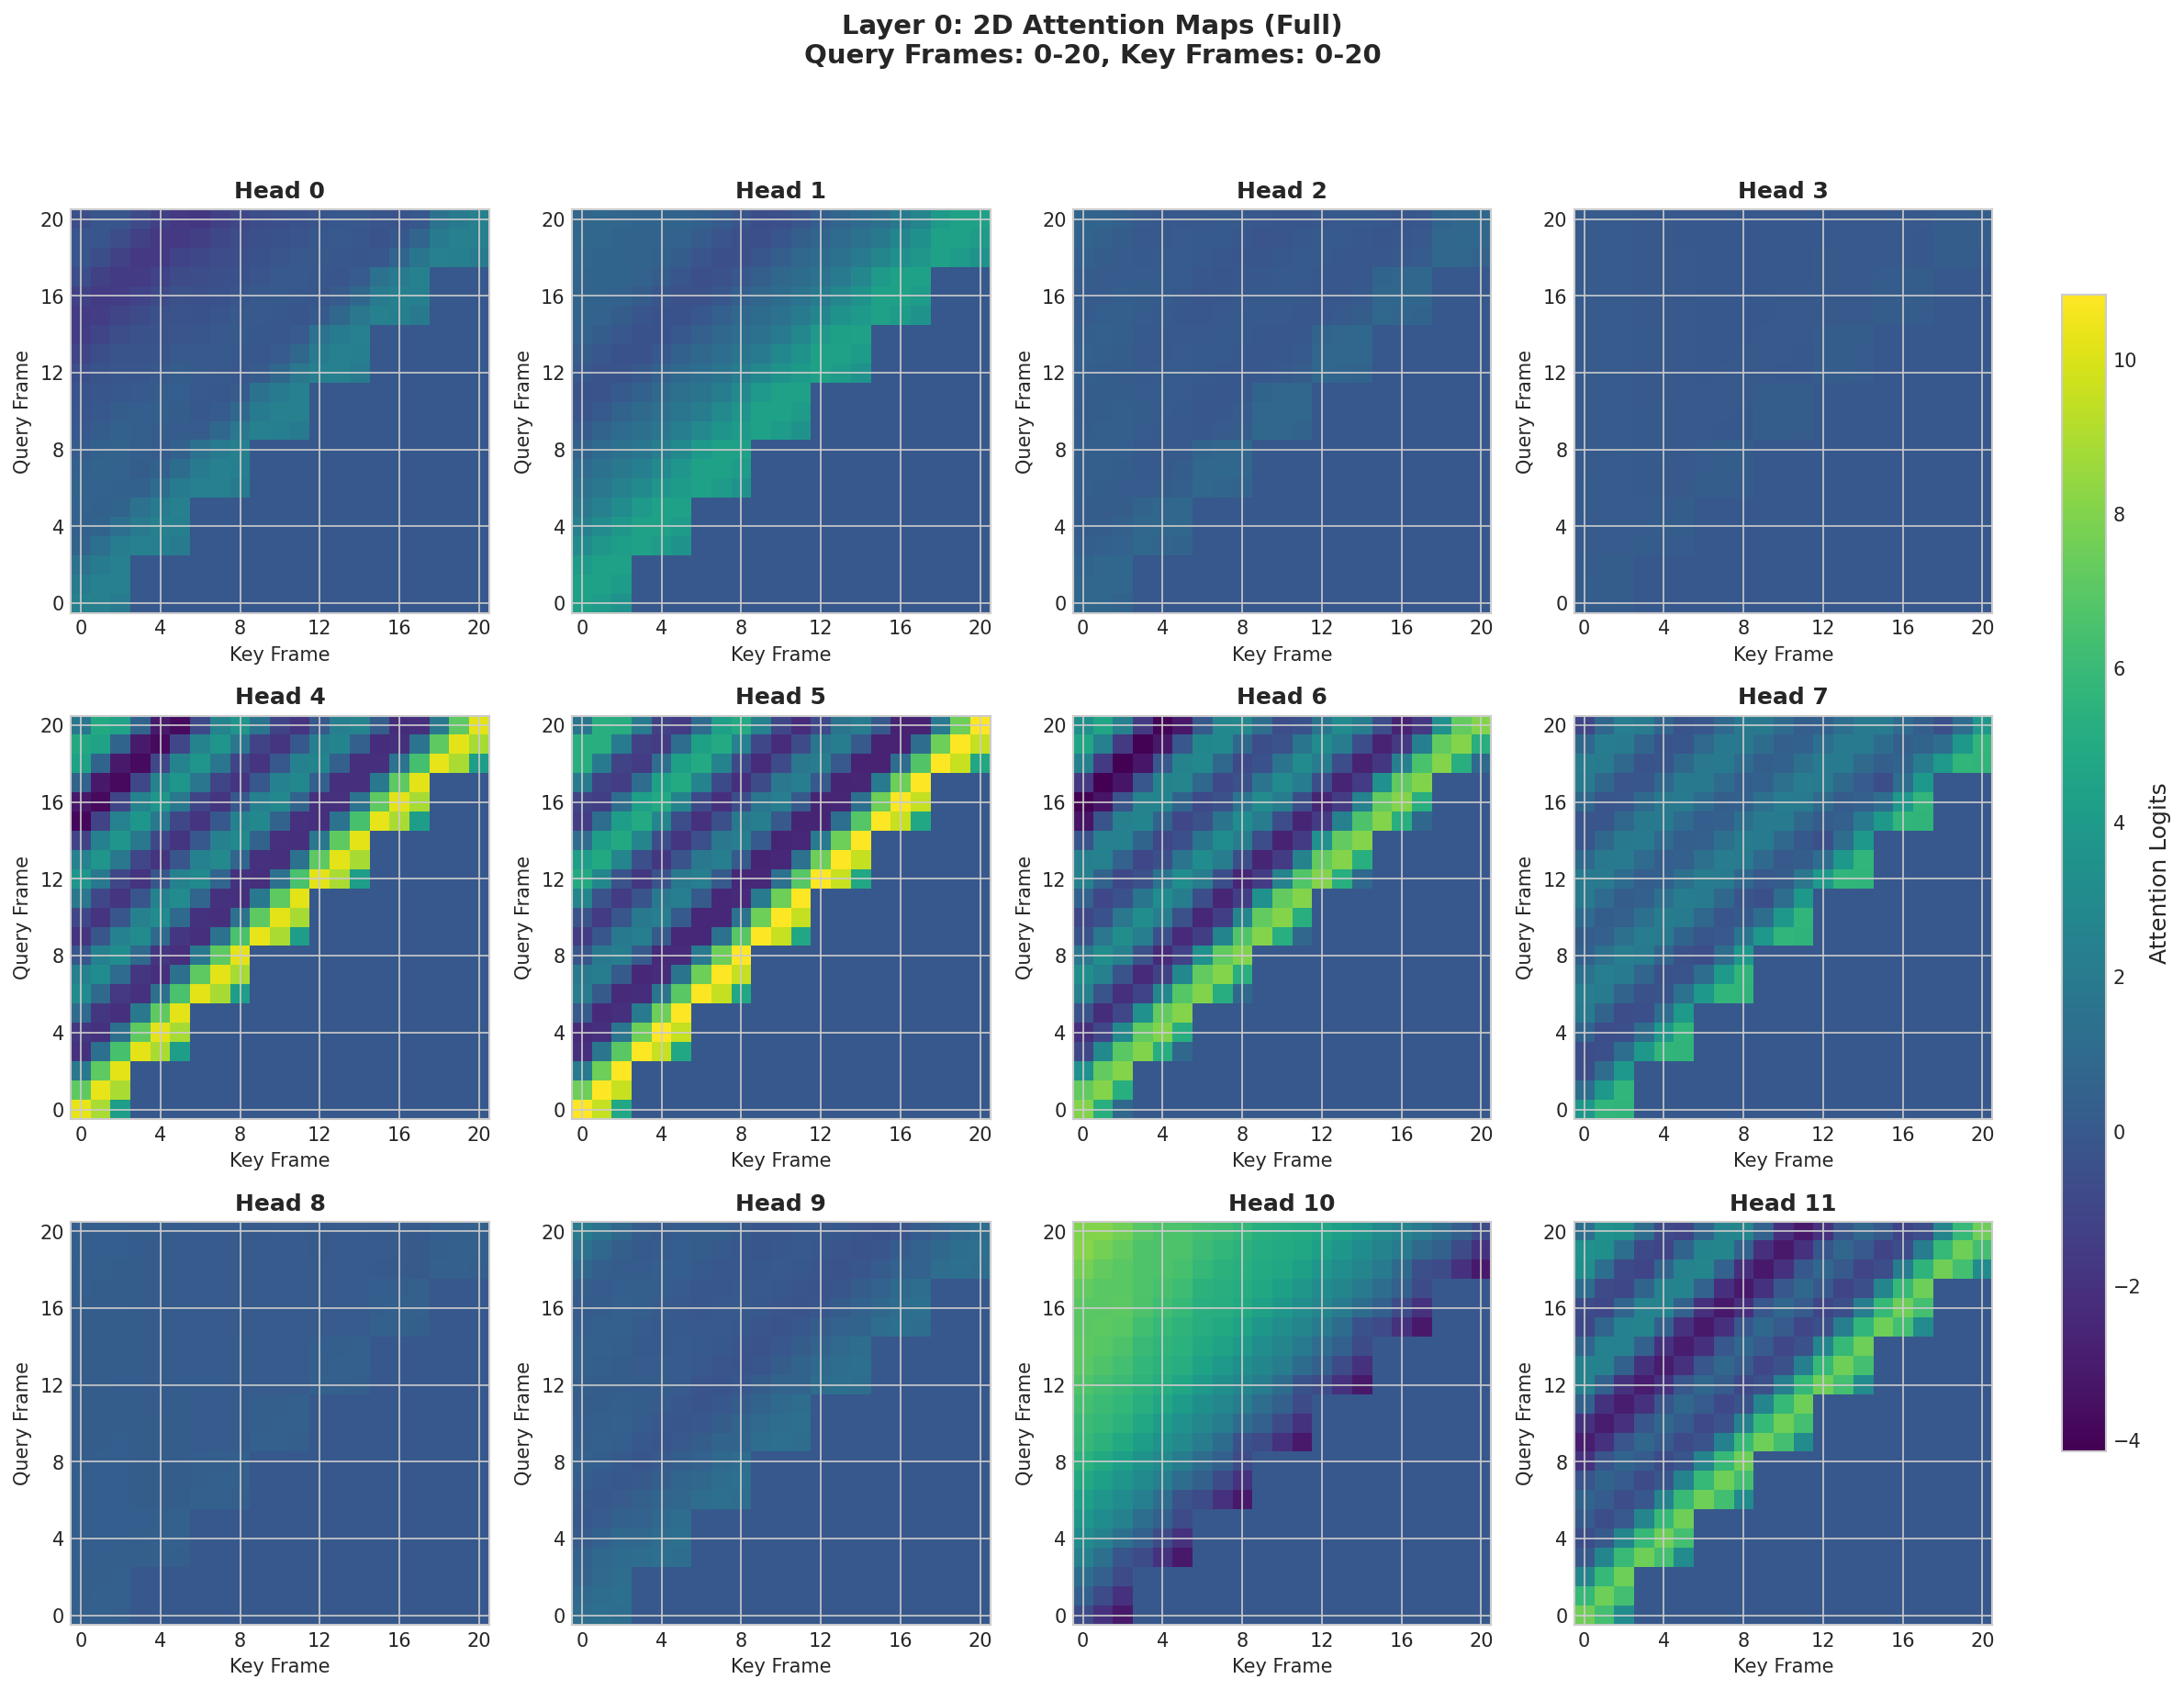

In [5]:
# ========== Plot 2D Attention Maps for All Heads ==========
print("=" * 70)
print(f"Plotting 2D Attention Maps for Layer {LAYER_TO_VISUALIZE}")
print("=" * 70)

# Determine grid layout
ncols = 4
nrows = math.ceil(num_heads / ncols)

# Adjust figure size based on matrix dimensions
aspect_ratio = num_k_frames / num_q_frames if num_q_frames > 0 else 1
fig_width = 4 * ncols
fig_height = 4 * nrows / aspect_ratio if aspect_ratio > 1 else 4 * nrows

fig, axes = plt.subplots(nrows, ncols, figsize=(fig_width, fig_height))
axes = axes.flatten()

# Compute global vmin/vmax for consistent colorbar
vmin = frame_attn_2d.min()
vmax = frame_attn_2d.max()

for h in range(num_heads):
    ax = axes[h]

    # Get 2D attention map: [num_q_frames, num_k_frames]
    attn_map = frame_attn_2d[h]

    # Plot heatmap
    im = ax.imshow(
        attn_map,
        cmap="viridis",
        aspect="auto",
        origin="lower",
        vmin=vmin,
        vmax=vmax,
        interpolation="nearest"
    )

    ax.set_title(f"Head {h}", fontsize=12, fontweight="bold")
    ax.set_xlabel("Key Frame", fontsize=10)
    ax.set_ylabel("Query Frame", fontsize=10)

    # Set Y-axis ticks
    if num_q_frames <= 10:
        ax.set_yticks(range(num_q_frames))
        ax.set_yticklabels(query_frames)
    else:
        step = max(1, num_q_frames // 5)
        tick_pos = range(0, num_q_frames, step)
        ax.set_yticks(list(tick_pos))
        ax.set_yticklabels([query_frames[i] for i in tick_pos])

    # Set X-axis ticks
    if num_k_frames <= 10:
        ax.set_xticks(range(num_k_frames))
        ax.set_xticklabels(key_frames)
    else:
        step = max(1, num_k_frames // 5)
        tick_pos = range(0, num_k_frames, step)
        ax.set_xticks(list(tick_pos))
        ax.set_xticklabels([key_frames[i] for i in tick_pos])

# Hide unused subplots
for k in range(num_heads, len(axes)):
    axes[k].axis("off")

# Add colorbar
fig.subplots_adjust(right=0.92)
cbar_ax = fig.add_axes([0.94, 0.15, 0.02, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label("Attention Logits", fontsize=12)

# Main title
matrix_type = "Full" if DATA_TYPE == "full_matrix" else "Last Block Only"
fig.suptitle(
    f"Layer {LAYER_TO_VISUALIZE}: 2D Attention Maps ({matrix_type})\n"
    f"Query Frames: {query_frames[0]}-{query_frames[-1]}, Key Frames: {key_frames[0]}-{key_frames[-1]}",
    fontsize=14,
    fontweight="bold",
    y=1.02
)

plt.tight_layout(rect=[0, 0, 0.92, 0.98])

# Save
output_path = f"cross_attention_layer{LAYER_TO_VISUALIZE}_all_heads.svg"
plt.savefig(output_path, format="svg", bbox_inches="tight")
print(f"Saved: {output_path}")

plt.show()

Saved: cross_attention_layer0_head0_large.svg


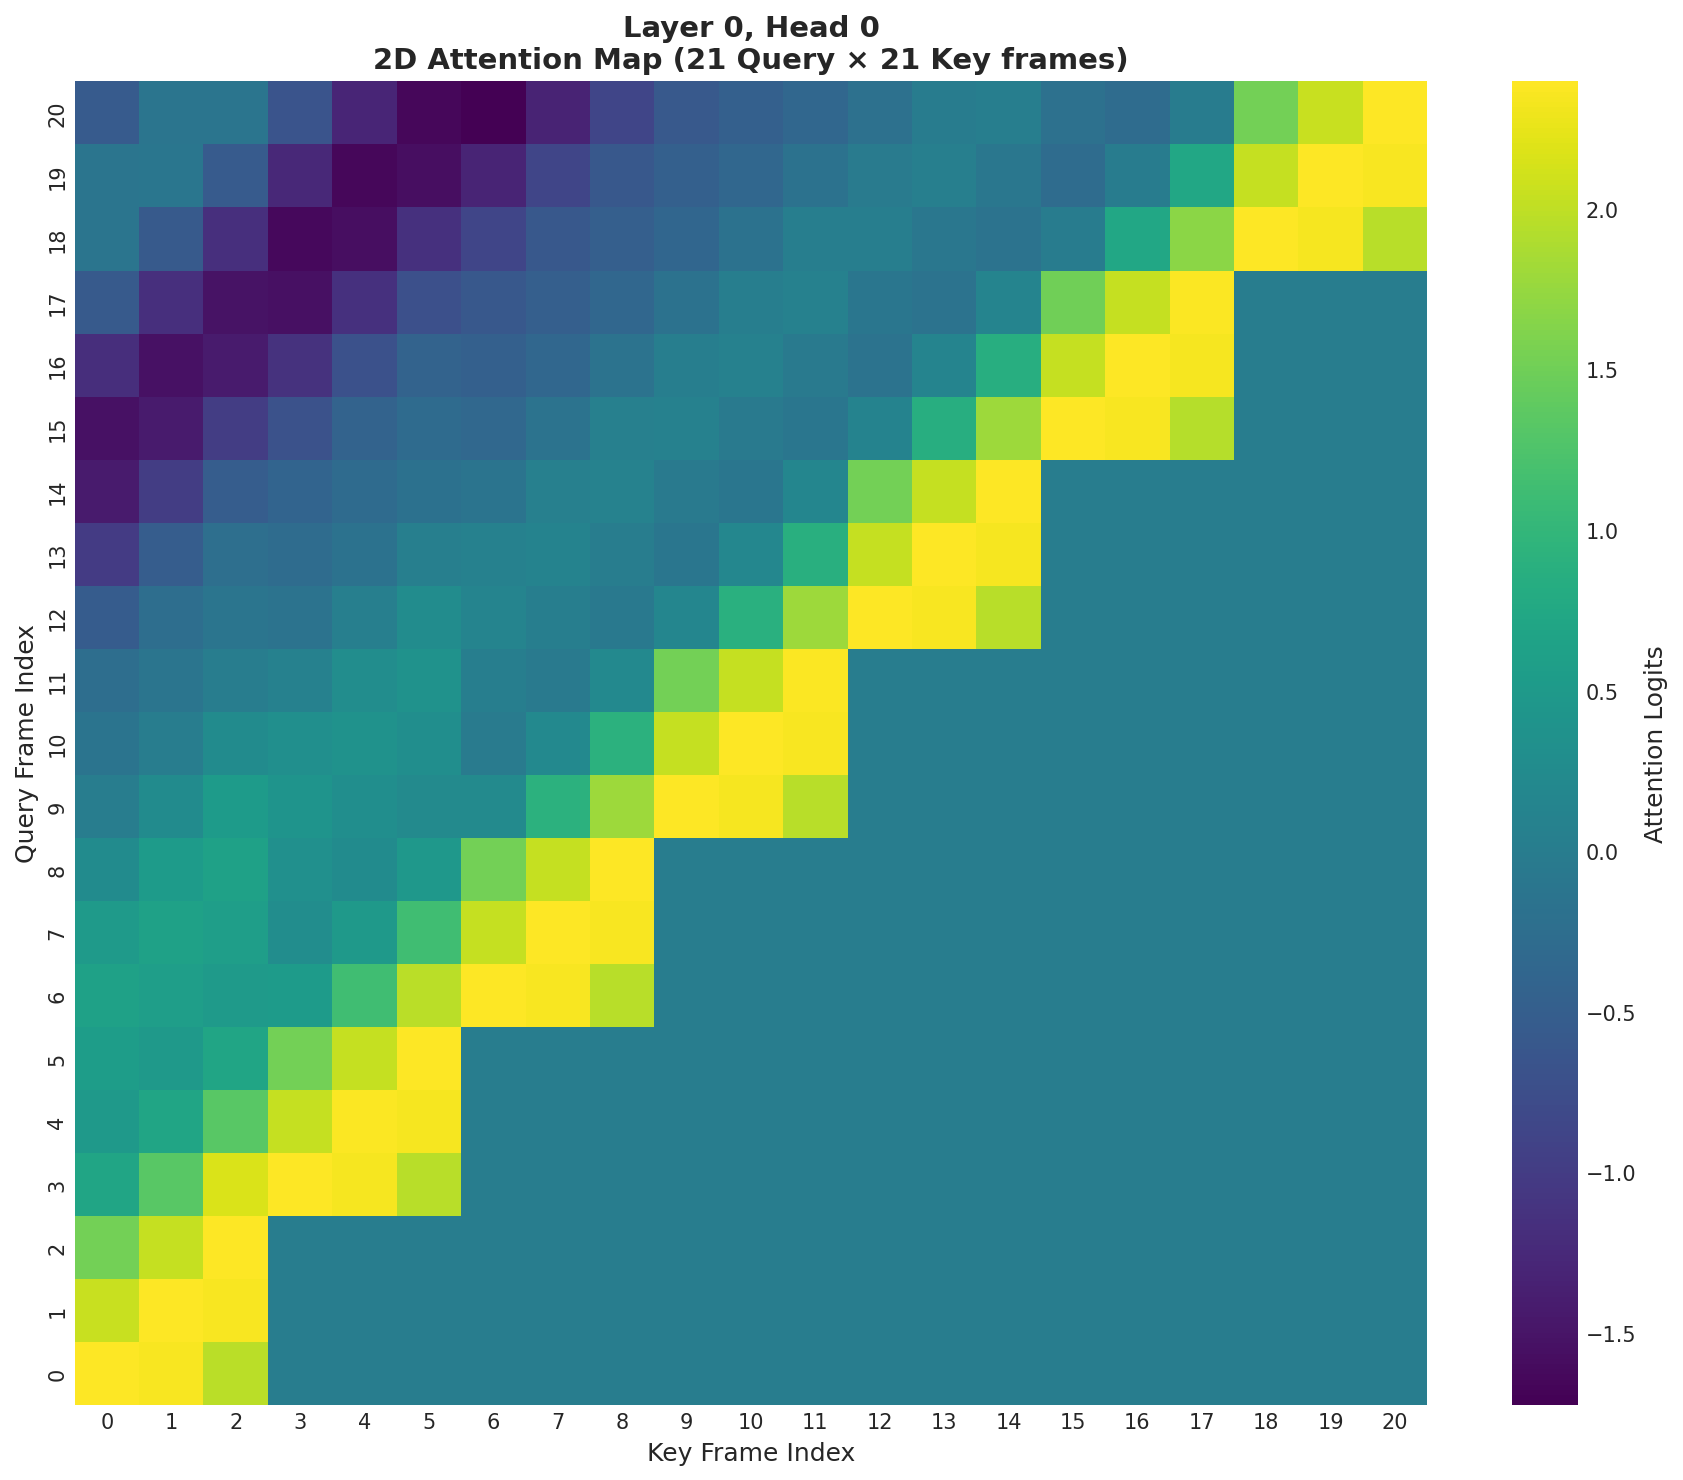

In [6]:
# ========== Plot Single Head (Large) with Annotations ==========
HEAD_TO_VISUALIZE = 0  # Change to visualize different heads

fig, ax = plt.subplots(figsize=(12, 10))

attn_map = frame_attn_2d[HEAD_TO_VISUALIZE]

# Use seaborn for better heatmap with annotations
show_annot = num_q_frames <= 15 and num_k_frames <= 15  # Only annotate small matrices

sns.heatmap(
    attn_map,
    ax=ax,
    cmap="viridis",
    annot=show_annot,
    fmt=".1f" if show_annot else None,
    annot_kws={"fontsize": 8} if show_annot else None,
    cbar_kws={"label": "Attention Logits"},
    xticklabels=key_frames if num_k_frames <= 25 else False,
    yticklabels=query_frames if num_q_frames <= 25 else False,
)

ax.set_title(
    f"Layer {LAYER_TO_VISUALIZE}, Head {HEAD_TO_VISUALIZE}\n"
    f"2D Attention Map ({num_q_frames} Query × {num_k_frames} Key frames)",
    fontsize=14,
    fontweight="bold"
)
ax.set_xlabel("Key Frame Index", fontsize=12)
ax.set_ylabel("Query Frame Index", fontsize=12)

# Invert Y axis so frame 0 is at top (natural reading order)
ax.invert_yaxis()

plt.tight_layout()

output_path = f"cross_attention_layer{LAYER_TO_VISUALIZE}_head{HEAD_TO_VISUALIZE}_large.svg"
plt.savefig(output_path, format="svg", bbox_inches="tight")
print(f"Saved: {output_path}")

plt.show()

In [7]:
# ========== Analyze Attention Patterns ==========
print("=" * 70)
print(f"Attention Pattern Analysis for Layer {LAYER_TO_VISUALIZE}")
print("=" * 70)

for h in range(num_heads):
    attn_map = frame_attn_2d[h]
    print(f"\nHead {h}:")
    print(f"  Min: {attn_map.min():.4f}, Max: {attn_map.max():.4f}, Mean: {attn_map.mean():.4f}")

    # For full matrix, analyze diagonal and off-diagonal
    if DATA_TYPE == "full_matrix" and num_q_frames == num_k_frames:
        diag = np.diag(attn_map)
        diag_mean = diag.mean()

        # First frame attention (attention sink)
        first_col = attn_map[:, 0]
        first_col_mean = first_col[first_col != 0].mean() if (first_col != 0).any() else 0

        # Recent frames attention (local pattern)
        recent_attn = []
        for i in range(1, num_q_frames):
            if i > 0:
                recent_attn.append(attn_map[i, max(0, i-3):i].mean())
        recent_mean = np.mean(recent_attn) if recent_attn else 0

        print(f"  Diagonal (self-attention): {diag_mean:.4f}")
        print(f"  First frame (sink): {first_col_mean:.4f}")
        print(f"  Recent 3 frames: {recent_mean:.4f}")
    else:
        # For last-block data, find max attention per query
        for qf_idx in range(min(3, num_q_frames)):
            max_k = attn_map[qf_idx].argmax()
            max_val = attn_map[qf_idx].max()
            qf_label = query_frames[qf_idx] if qf_idx < len(query_frames) else qf_idx
            print(f"  Query {qf_label} -> Max attention to Key {max_k} ({max_val:.2f})")

Attention Pattern Analysis for Layer 0

Head 0:
  Min: -1.7236, Max: 2.3984, Mean: 0.2649
  Diagonal (self-attention): 2.3876
  First frame (sink): 0.0799
  Recent 3 frames: 1.2180

Head 1:
  Min: -0.5469, Max: 4.4492, Mean: 1.1235
  Diagonal (self-attention): 4.4407
  First frame (sink): 1.3378
  Recent 3 frames: 3.6920

Head 2:
  Min: -0.1653, Max: 0.8647, Mean: 0.1697
  Diagonal (self-attention): 0.8545
  First frame (sink): 0.4174
  Recent 3 frames: 0.3889

Head 3:
  Min: -0.0431, Max: 0.2627, Mean: 0.0628
  Diagonal (self-attention): 0.2564
  First frame (sink): 0.1780
  Recent 3 frames: 0.1240

Head 4:
  Min: -3.8066, Max: 10.2734, Mean: 1.3143
  Diagonal (self-attention): 10.2515
  First frame (sink): 1.4849
  Recent 3 frames: 2.5235

Head 5:
  Min: -2.7070, Max: 10.8438, Mean: 1.4724
  Diagonal (self-attention): 10.8162
  First frame (sink): 2.0601
  Recent 3 frames: 2.5966

Head 6:
  Min: -4.1445, Max: 8.0625, Mean: 1.0934
  Diagonal (self-attention): 8.0450
  First frame (sin

Saved: cross_attention_layer0_head_average.svg


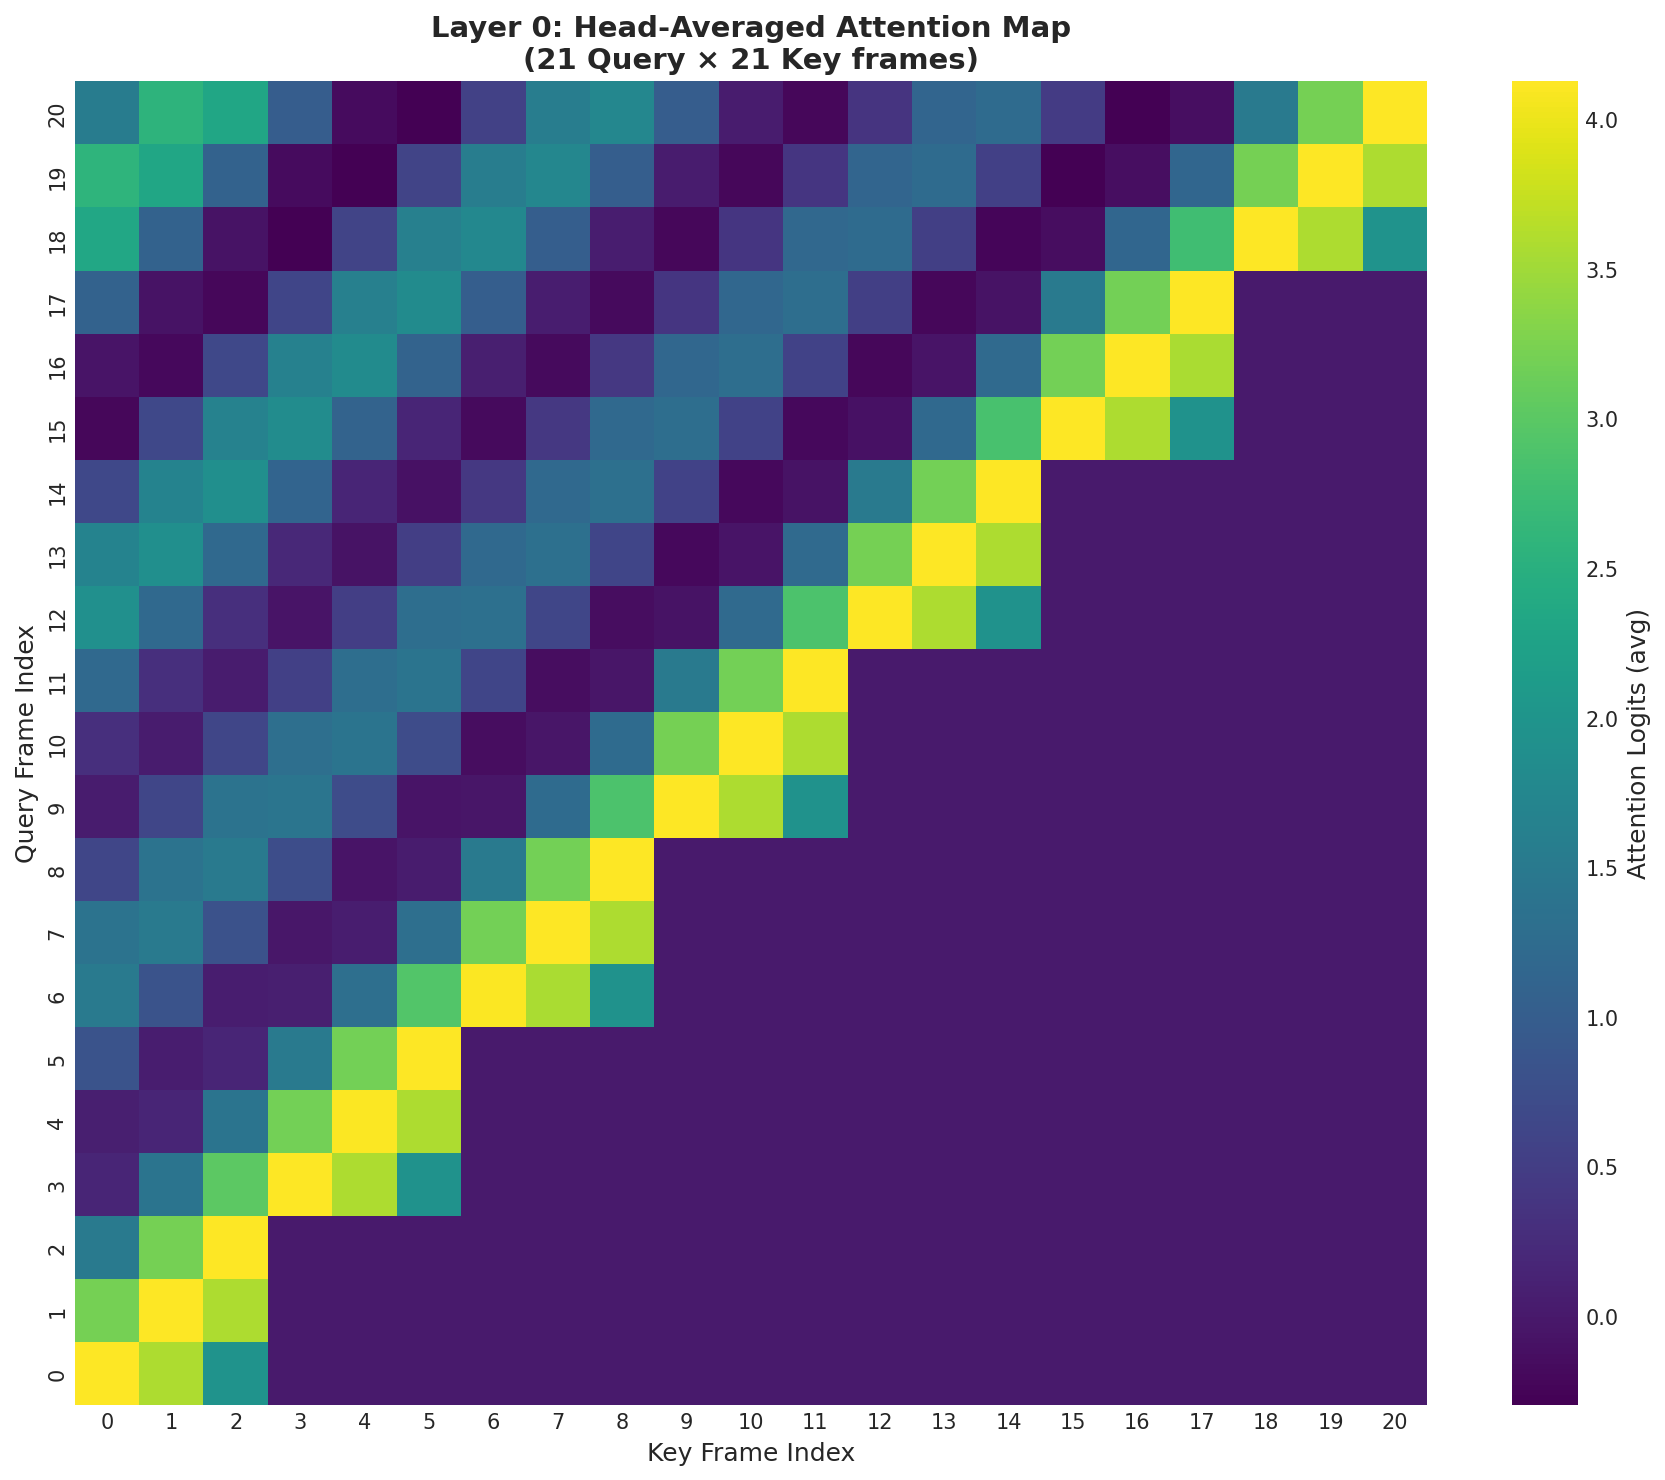

In [8]:
# ========== Plot Head-Averaged Attention Map ==========
fig, ax = plt.subplots(figsize=(12, 10))

# Average across all heads
avg_attn = frame_attn_2d.mean(axis=0)  # [num_q_frames, num_k_frames]

show_annot = num_q_frames <= 15 and num_k_frames <= 15

sns.heatmap(
    avg_attn,
    ax=ax,
    cmap="viridis",
    annot=show_annot,
    fmt=".1f" if show_annot else None,
    annot_kws={"fontsize": 8} if show_annot else None,
    cbar_kws={"label": "Attention Logits (avg)"},
    xticklabels=key_frames if num_k_frames <= 25 else False,
    yticklabels=query_frames if num_q_frames <= 25 else False,
)

ax.set_title(
    f"Layer {LAYER_TO_VISUALIZE}: Head-Averaged Attention Map\n"
    f"({num_q_frames} Query × {num_k_frames} Key frames)",
    fontsize=14,
    fontweight="bold"
)
ax.set_xlabel("Key Frame Index", fontsize=12)
ax.set_ylabel("Query Frame Index", fontsize=12)
ax.invert_yaxis()

plt.tight_layout()

output_path = f"cross_attention_layer{LAYER_TO_VISUALIZE}_head_average.svg"
plt.savefig(output_path, format="svg", bbox_inches="tight")
print(f"Saved: {output_path}")

plt.show()

Available layers: [0, 4]
Saved: cross_attention_layer_comparison.svg


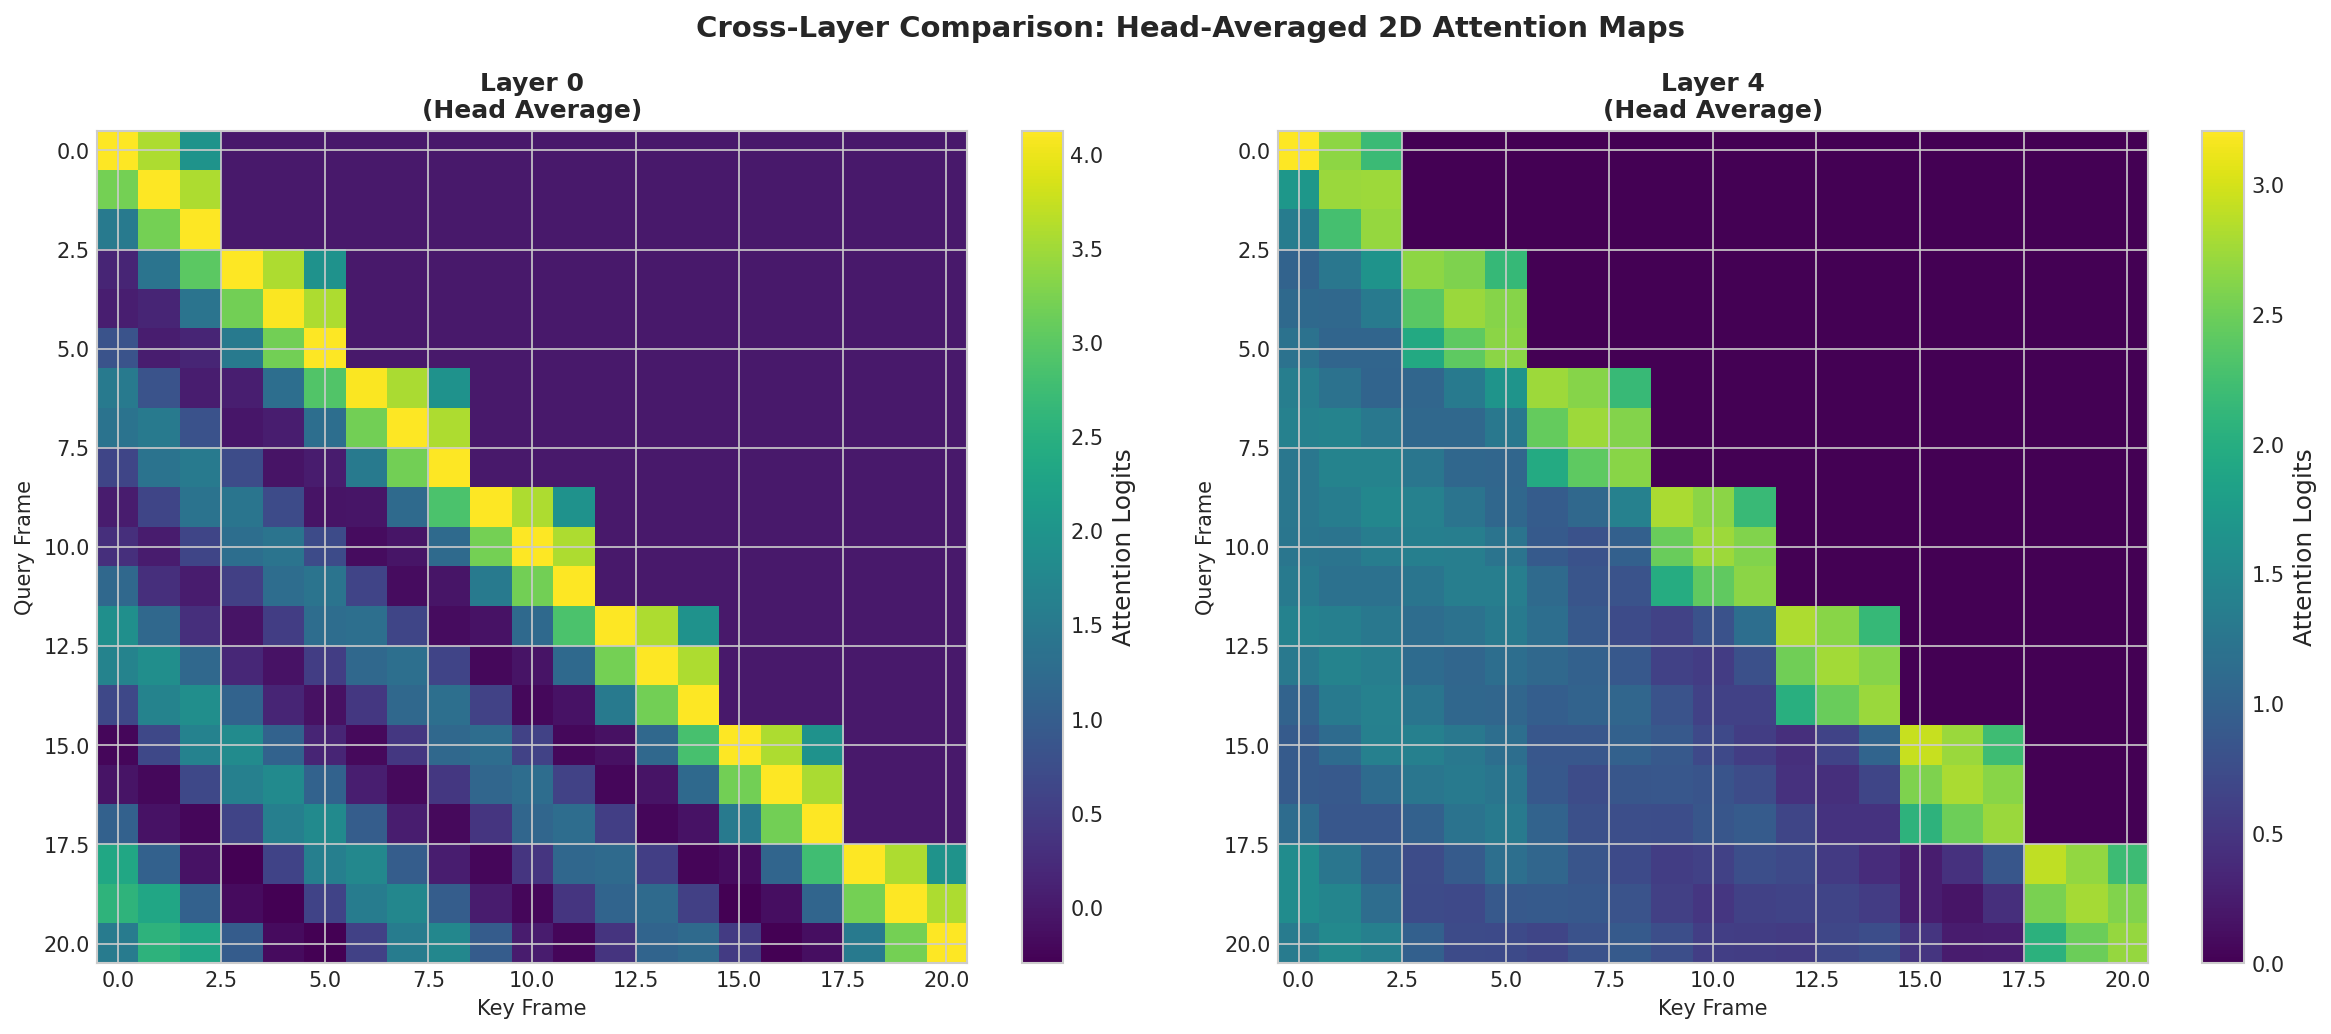

In [9]:
# ========== Compare All Available Layers ==========
available_layers = sorted(layer_attention_data.keys())
print(f"Available layers: {available_layers}")

if len(available_layers) > 1:
    fig, axes = plt.subplots(1, len(available_layers), figsize=(8 * len(available_layers), 7))
    if len(available_layers) == 1:
        axes = [axes]

    for idx, layer_idx in enumerate(available_layers):
        ax = axes[idx]
        layer_data = layer_attention_data[layer_idx]
        avg_attn = layer_data["frame_attention"].mean(axis=0)
        q_frames = layer_data["query_frame_indices"]
        k_frames = layer_data["key_frame_indices"]

        im = ax.imshow(
            avg_attn,
            cmap="viridis",
            aspect="auto",
            origin="upper",
            interpolation="nearest"
        )

        ax.set_title(f"Layer {layer_idx}\n(Head Average)", fontsize=12, fontweight="bold")
        ax.set_xlabel("Key Frame", fontsize=10)
        ax.set_ylabel("Query Frame", fontsize=10)

        # Ticks
        nq, nk = avg_attn.shape
        if nq <= 10:
            ax.set_yticks(range(nq))
            ax.set_yticklabels(q_frames)
        if nk <= 10:
            ax.set_xticks(range(nk))
            ax.set_xticklabels(k_frames)

        plt.colorbar(im, ax=ax, label="Attention Logits")

    fig.suptitle(
        "Cross-Layer Comparison: Head-Averaged 2D Attention Maps",
        fontsize=14,
        fontweight="bold"
    )

    plt.tight_layout()
    plt.savefig("cross_attention_layer_comparison.svg", format="svg", bbox_inches="tight")
    print("Saved: cross_attention_layer_comparison.svg")
    plt.show()

In [10]:
# ========== Summary ==========
print("=" * 70)
print("Generated Figures")
print("=" * 70)
print(f"1. cross_attention_layer{LAYER_TO_VISUALIZE}_all_heads.svg - All heads grid")
print(f"2. cross_attention_layer{LAYER_TO_VISUALIZE}_head{HEAD_TO_VISUALIZE}_large.svg - Single head detail")
print(f"3. cross_attention_layer{LAYER_TO_VISUALIZE}_head_average.svg - Head-averaged map")
if len(available_layers) > 1:
    print(f"4. cross_attention_layer_comparison.svg - Cross-layer comparison")

print("\n" + "=" * 70)
print("Data Info")
print("=" * 70)
print(f"Data type: {DATA_TYPE}")
print(f"Num frames: Q={num_q_frames}, K={num_k_frames}")
print(f"Num heads: {num_heads}")
print(f"Layers: {available_layers}")

if DATA_TYPE == "last_block":
    print("\n" + "=" * 70)
    print("To get full 21x21 attention matrix, run:")
    print("=" * 70)
    print("PYTHONPATH=. python experiments/run_extraction_full_attention.py --no_checkpoint")

Generated Figures
1. cross_attention_layer0_all_heads.svg - All heads grid
2. cross_attention_layer0_head0_large.svg - Single head detail
3. cross_attention_layer0_head_average.svg - Head-averaged map
4. cross_attention_layer_comparison.svg - Cross-layer comparison

Data Info
Data type: full_matrix
Num frames: Q=21, K=21
Num heads: 12
Layers: [0, 4]
